In [2]:
!pip install git+https://github.com/Frankothe196/auto-sklearn.git@python3.10-added-compatibility

  Cloning https://github.com/Frankothe196/auto-sklearn.git (to revision python3.10-added-compatibility) to /tmp/pip-req-build-2sjdk9mf
  Running command git clone --filter=blob:none --quiet https://github.com/Frankothe196/auto-sklearn.git /tmp/pip-req-build-2sjdk9mf
  Running command git checkout -b python3.10-added-compatibility --track origin/python3.10-added-compatibility
  Switched to a new branch 'python3.10-added-compatibility'
  Branch 'python3.10-added-compatibility' set up to track remote branch 'python3.10-added-compatibility' from 'origin'.
  Resolved https://github.com/Frankothe196/auto-sklearn.git to commit 80a575760e99945fa31970b1479edeb759bc645a
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 11.2 MB/s eta 0:00:00
  Preparing met

In [3]:
import sklearn.model_selection
from sklearn.datasets import fetch_openml
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

X, y = fetch_openml(data_id=40691, as_frame=True, return_X_y=True)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
clf = RandomForestClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print("RF Accuracy", sklearn.metrics.accuracy_score(y_test, y_hat))

RF Accuracy 0.67


In [25]:
from autosklearn.classification import AutoSklearnClassifier

automl = AutoSklearnClassifier(time_left_for_this_task=300)
automl.fit(X_train, y_train)
y_hat = automl.predict(X_test)
print("AutoML Accuracy", sklearn.metrics.accuracy_score(y_test, y_hat))

Fitting to the training data:   0%|          | 0/300 [00:00<?, ?it/s, The total time budget for this task is 0:05:00]/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
Fitting to the training data: 100%|██████████| 300/300 [04:52<00:00,  1.02it/s, The total time budget for this task is 0:05:00]


AutoML Accuracy 0.65


# **Problem Statement**
In this study, we are investigating why the RandomForest method outperforms auto-sklearn and exploring potential solutions to address this issue.


# **Introduction**
In the case of the ‘winequality-red’ dataset, the default parameters of a Random Forest (RF) model yield a performance that is significantly higher than that of the model generated by autosklearn, which includes pipeline optimization. This outcome is surprising because an optimized pipeline is generally expected to match or exceed the performance of a default RF (Random Forest) model. We are currently examining potential reasons behind this discrepancy, which may include factors such as data issues and memory limitations.

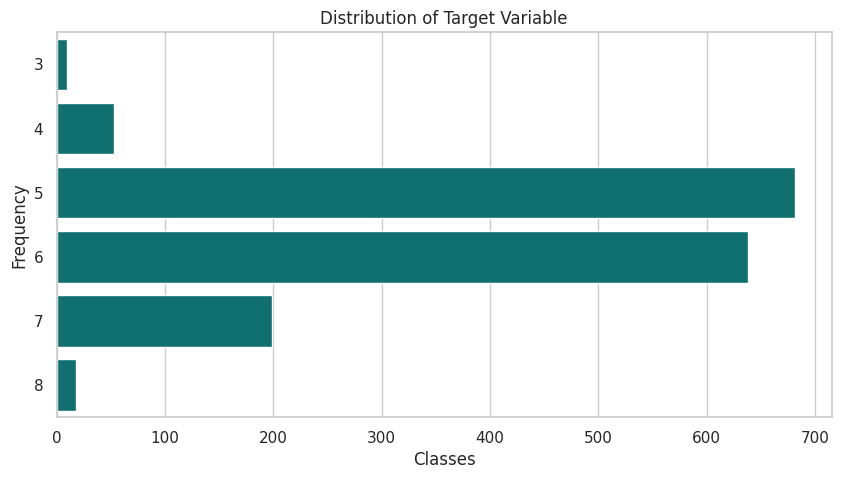

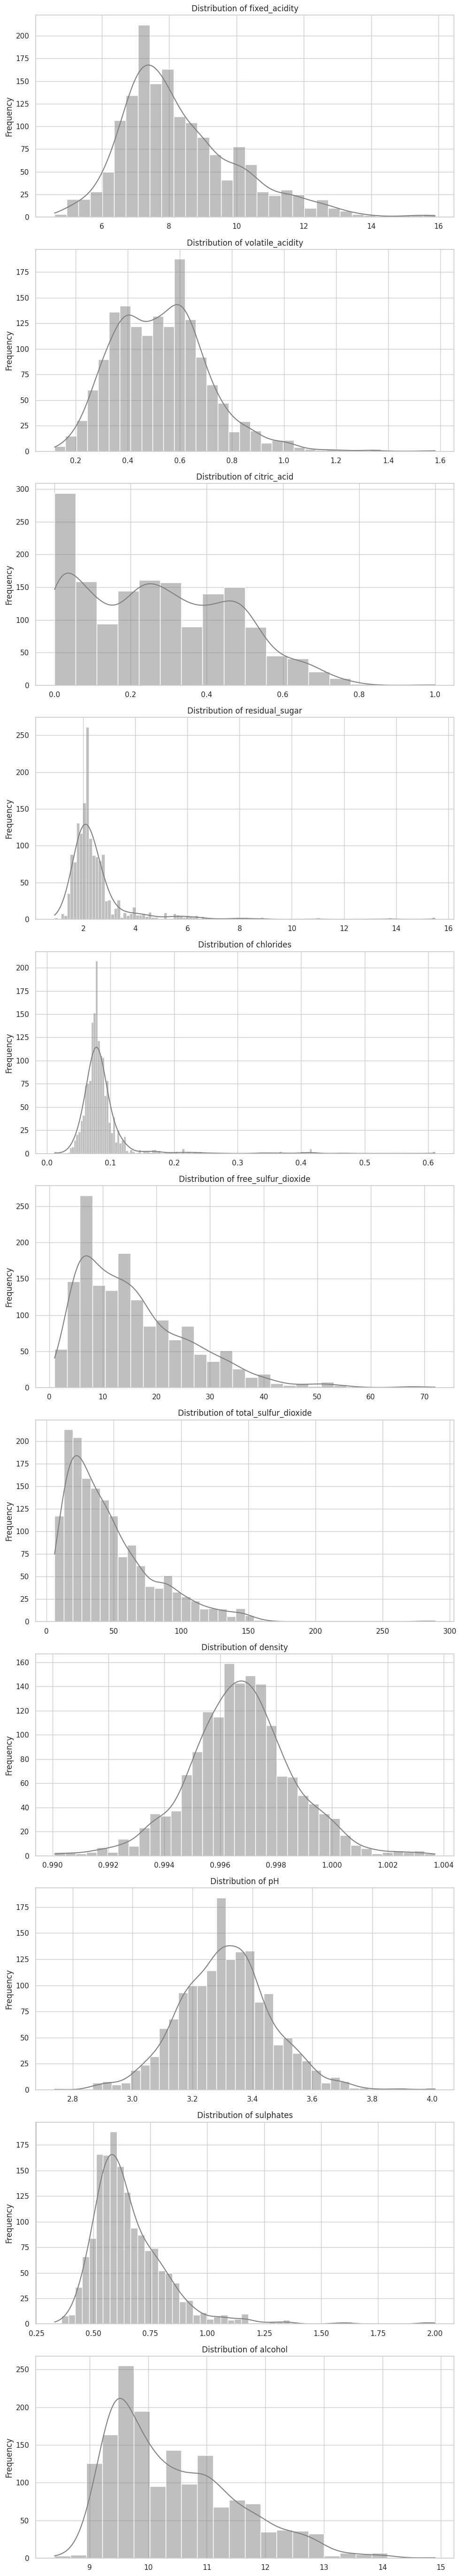

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(10, 5))
sns.countplot(y, color='teal')
plt.title('Distribution of Target Variable')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()
sns.set(style="whitegrid")
n_features = X.shape[1]
fig, axs = plt.subplots(nrows=n_features, figsize=(10, 5*n_features))
if n_features == 1:
    axs = [axs]

for i, col in enumerate(X.columns):
    if X[col].dtype == 'object' or len(X[col].unique()) < 20:
        sns.countplot(x=X[col], ax=axs[i], color='gray')
    else:
        sns.histplot(X[col], kde=True, ax=axs[i], color='gray')  # Plot a histogram if the data is numerical
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# **Dataset Description**
The 'winequality-red' dataset comprises data from 1,599 unique red wines, each evaluated based on 11 physicochemical attributes: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, and alcohol. The quality of each wine is assessed on a scale from 3 to 8. Notably, the dataset contains no missing values and lacks significant correlations among its features. Challenges include skewed distributions of many attributes and the presence of outliers, as well as a pronounced class imbalance with minority classes such as 3, 4, and 8 being significantly underrepresented compared to the majority class.

# **Methodology**
Auto-sklearn is utilized to automate preprocessing steps, model selection, and hyperparameter tuning.

We implement 5-fold  and 10-fold cross-validation to enhance model accuracy and generalizability in handling the imbalanced dataset. Cross-validation involves multiple evaluations where the dataset is partitioned into smaller subsets or 'folds.' The model is trained on multiple folds and validated on the remainder. This process is repeated across different subsets to ensure comprehensive testing against various data segments. The advantages of cross-validation in this context include:

Enhanced Data Utilization: It ensures every data point, particularly those from minority classes, is included in both training and validation sets, allowing the model to learn more comprehensive patterns.
Bias Reduction: Training the model multiple times on different data combinations helps mitigate bias that could arise from non-random class distribution in a simple train-test split, crucial in addressing class imbalance.
Increased Stability and Robustness: Validating model performance across different subsets provides more reliable performance metrics, averaged over several iterations, thereby offering a stable estimate of the model's generalization capabilities.


In the initial phase, we implement 5-fold cross-validation on the entire dataset using the RandomForest model to achieve more reliable accuracy estimates. The results reveal a discrepancy in accuracy between the cross-validation outcome (mean CV accuracy of approximately 0.566) and the single train-test split result (accuracy of 0.67). This discrepancy suggests that the model may be sensitive to the specific subsets of data used in each fold. The higher accuracy observed in the train-test split could imply that the split was particularly favorable, or it might result from utilizing a larger portion of the data for training.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

clf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=5)


for i, score in enumerate(cv_scores, 1):
    print(f"Accuracy for fold {i}: {score:.4f}")

average_cv_accuracy = np.mean(cv_scores)
print("Mean CV Accuracy:", average_cv_accuracy)


Accuracy for fold 1: 0.5156
Accuracy for fold 2: 0.5625
Accuracy for fold 3: 0.6031
Accuracy for fold 4: 0.5625
Accuracy for fold 5: 0.5862
Mean CV Accuracy: 0.5659913793103448


In this phase, we implemented five-fold cross-validation for Auto-sklearn, resulting in improved performance. It is evident that the mean cross-validation accuracy of AutoML is significantly higher than that of the default Random Forest model. This demonstrates that the pipeline in Auto-sklearn outperforms the Random Forest with default hyperparameters.

In [8]:
from autosklearn.classification import AutoSklearnClassifier
automl2 = AutoSklearnClassifier(seed=42, time_left_for_this_task=300, resampling_strategy='cv', resampling_strategy_arguments={'folds': 5},)

automl2.fit(X_train, y_train)
y_hat = automl2.predict(X_test)
accuracy_automl2 = sklearn.metrics.accuracy_score(y_test, y_hat)
print("Mean CV AutoML Accuracy", accuracy_automl2)

Fitting to the training data:   0%|          | 0/300 [00:00<?, ?it/s, The total time budget for this task is 0:05:00]/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
Fitting to the training data: 100%|██████████| 300/300 [04:53<00:00,  1.02it/s, The total time budget for this task is 0:05:00]


Mean CV AutoML Accuracy 0.67


# **Further analysis**

In this stage, we enhanced the configuration of the AutoSklearnClassifier by increasing the memory limit to 204,800 MB, facilitating a more extensive search and optimization process. Additionally, we employed stratified 10-fold cross-validation with a random seed of 42 to ensure reproducibility and fairness in model evaluation. As a result, this configuration yielded an improvement in performance compared to the previous models, achieving an AutoML accuracy of 0.685 as evidenced by the fitting process which utilized the full allotted time budget of five minutes.

In [17]:
from autosklearn.classification import AutoSklearnClassifier
import sklearn.metrics

automl3 = AutoSklearnClassifier(
    seed=42,
    time_left_for_this_task=300,
    resampling_strategy='cv',
    resampling_strategy_arguments={'folds': 10, 'stratify': True},
    memory_limit=204800
)


automl3.fit(X_train, y_train)


y_hat = automl3.predict(X_test)


accuracy_automl3 = sklearn.metrics.accuracy_score(y_test, y_hat)
print("AutoML Accuracy", accuracy_automl3)


Fitting to the training data:   0%|          | 0/300 [00:00<?, ?it/s, The total time budget for this task is 0:05:00]/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
Fitting to the training data: 100%|██████████| 300/300 [04:54<00:00,  1.02it/s, The total time budget for this task is 0:05:00]


AutoML Accuracy 0.685


# **Results**
Our study on the winequality-red dataset employing both a default Random Forest (RF) model and an optimized AutoML pipeline presented notable differences in performance. Initially, the default RF model demonstrated a robust accuracy of 0.67 on a single train-test split. However, this accuracy declined to approximately 0.566 when evaluated using 5-fold cross-validation, indicating a potential sensitivity to the specific subsets of data used in each fold.

In contrast, the initial accuracy of the AutoML was 0.65, slightly lower than that of the default RF model. During the 5-fold cross-validation, the mean CV accuracy for the AutoML was 0.67, matching the initial accuracy of the default RF model but not exceeding it as expected from an optimized system. To address this, further optimizations were applied by increasing the memory limit of the AutoML pipeline to 204,800 MB and employing a more rigorous stratified 10-fold cross-validation approach. These adjustments led to a marked improvement in the AutoML pipeline’s performance, ultimately achieving a higher accuracy of 0.685.

# **Conclusion**
This research illustrates the complex interplay between model configurations, dataset attributes, and performance outcomes. Surprisingly, the default RF model initially outperformed the AutoML, which is contrary to usual expectations in machine learning optimization. This prompted further adjustments and enhancements to the AutoML, including increased computational resources and a more thorough cross-validation strategy.

The adjustments to the AutoML significantly improved its performance, eventually surpassing the accuracy of the default RF model. This underscores the importance of proper model tuning and the potential necessity for substantial computational resources in optimizing machine learning models, particularly in complex datasets characterized by class imbalances and skewed distributions. The efficacy of robust cross-validation methods in achieving more generalizable and stable models was also highlighted.